In [8]:
import os
import numpy as np

def build_out_state_space(inputs_dir="./inputs-txt/"):
    datas = []
    #for filename in os.listdir(inputs_dir):
    #    tmp_data = np.genfromtxt("{}{}".format(inputs_dir,filename), delimiter=',')
    #    datas.append(add_more_inputs_to_data(tmp_data))
    tmp_data = np.genfromtxt("{}{}".format(inputs_dir,'training_data.txt'), delimiter=',')
    return tmp_data

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

# From here: https://gist.github.com/karpathy/d4dee566867f8291f086
#print data
"""
Minimal character-level Vanilla RNN model. Written by Andrej Karpathy (@karpathy)
BSD License
"""
import numpy as np

# hyperparameters
class RNN:
    def __init__(self, max_size, iterations, hidden_size=100, seq_length = 25, learning_rate=1e-1):
        self.vocab_size = max_size
        self.iterations = iterations
        self.hidden_size = hidden_size # size of hidden layer of neurons
        self.seq_length = seq_length # number of steps to unroll the RNN for
        self.learning_rate = learning_rate
        
    def lossFun(self, inputs, targets, hprev):
          """
          inputs,targets are both list of integers.
          hprev is Hx1 array of initial hidden state
          returns the loss, gradients on model parameters, and last hidden state
          """
          xs, hs, ys, ps = {}, {}, {}, {}
          hs[-1] = np.copy(hprev)
          loss = 0
          # forward pass
          for t in range(len(inputs)):
            xs[t] = np.zeros((self.vocab_size,1)) # encode in 1-of-k representation
            xs[t][inputs[t]] = 1
            hs[t] = np.tanh(np.dot(self.Wxh, xs[t]) + np.dot(self.Whh, hs[t-1]) + self.bh) # hidden state
            ys[t] = np.dot(self.Why, hs[t]) + self.by # unnormalized log probabilities for next chars
            ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars
            loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss)
          # backward pass: compute gradients going backwards
          dWxh, dWhh, dWhy = np.zeros_like(self.Wxh), np.zeros_like(self.Whh), np.zeros_like(self.Why)
          dbh, dby = np.zeros_like(self.bh), np.zeros_like(self.by)
          dhnext = np.zeros_like(hs[0])
          for t in reversed(range(len(inputs))):
            dy = np.copy(ps[t])
            dy[targets[t]] -= 1 # backprop into y. see http://cs231n.github.io/neural-networks-case-study/#grad if confused here
            dWhy += np.dot(dy, hs[t].T)
            dby += dy
            dh = np.dot(self.Why.T, dy) + dhnext # backprop into h
            dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity
            dbh += dhraw
            dWxh += np.dot(dhraw, xs[t].T)
            dWhh += np.dot(dhraw, hs[t-1].T)
            dhnext = np.dot(self.Whh.T, dhraw)
          for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
            np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients
          return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs)-1]

    def sample(self, h, seed_ix, n):
      """ 
      sample a sequence of integers from the model 
      h is memory state, seed_ix is seed letter for first time step
      """
      x = np.zeros((self.vocab_size, 1))
      x[seed_ix] = 1
      ixes = []
      for t in range(n):
        h = np.tanh(np.dot(self.Wxh, x) + np.dot(self.Whh, h) + self.bh)
        y = np.dot(self.Why, h) + self.by
        p = np.exp(y) / np.sum(np.exp(y))
        #plt.plot(range(self.vocab_size), p.ravel())
        #plt.show()
        ix = np.random.choice(range(self.vocab_size), p=p.ravel(), size=5)
        x = np.zeros((self.vocab_size, 1))
        x[ix] = 1
        ixes.append(ix.mean())
      return ixes

    def train(self, data):
        
        # model parameters
        self.Wxh = np.random.randn(self.hidden_size, self.vocab_size)*0.01 # input to hidden
        self.Whh = np.random.randn(self.hidden_size, self.hidden_size)*0.01 # hidden to hidden
        self.Why = np.random.randn(self.vocab_size, self.hidden_size)*0.01 # hidden to output
        self.bh = np.zeros((self.hidden_size, 1)) # hidden bias
        self.by = np.zeros((self.vocab_size, 1)) # output bias

        n, p = 0, 0
        mWxh, mWhh, mWhy = np.zeros_like(self.Wxh), np.zeros_like(self.Whh), np.zeros_like(self.Why)
        mbh, mby = np.zeros_like(self.bh), np.zeros_like(self.by) # memory variables for Adagrad
        smooth_loss = -np.log(1.0/self.vocab_size)*self.seq_length # loss at iteration 0
        self.smooth_loss_list = []
        while n <= self.iterations:
          # prepare inputs (we're sweeping from left to right in steps seq_length long)
          if p+self.seq_length+1 >= len(data) or n == 0: 
            hprev = np.zeros((self.hidden_size,1)) # reset RNN memory
            p = 0 # go from start of data
          inputs = data[p:p+self.seq_length]
          targets = data[p+1:p+self.seq_length+1]

          # forward seq_length characters through the net and fetch gradient
          loss, dWxh, dWhh, dWhy, dbh, dby, hprev = self.lossFun(inputs, targets, hprev)
          smooth_loss = smooth_loss * 0.999 + loss * 0.001
          if n % 1000 == 0: 
                print ('iter %d, loss: %f' % (n, smooth_loss) )# print progress
          self.smooth_loss_list.append(smooth_loss)

          # perform parameter update with Adagrad
          for param, dparam, mem in zip([self.Wxh, self.Whh, self.Why, self.bh, self.by], 
                                        [dWxh, dWhh, dWhy, dbh, dby], 
                                        [mWxh, mWhh, mWhy, mbh, mby]):
            
            #print mem.shape, dparam.shape
            mem += dparam * dparam
            param += -self.learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update

          p += self.seq_length # move data pointer
          n += 1 # iteration counter 
        self.hprev = hprev
        
        #print "Final Run"
        #sample_ix = sample(hprev, inputs[0], 200)
        #return sample_ix
    #    txt = ''.join(map(str,sample_ix))
    #    print '----\n %s \n----' % (txt, )

Populating the interactive namespace from numpy and matplotlib


In [10]:
d = build_out_state_space()
X_Max = int(np.max(np.array(d)[:,0]))+1
Y_Max = int(np.max(np.array(d)[:,1]))+1
X = np.array(d, dtype=np.uint16)[:,0]
Y = np.array(d, dtype=np.uint16)[:,1]

#plt.scatter(range(len(X)), X)
#plt.grid()
#plt.ylim((0,X_Max))
#plt.show()

In [12]:
# plt.scatter(range(len(Y)), Y)
# plt.show()

In [16]:
print (Y_Max, X_Max)
hidden_size = 200
seq_length = 100
iterations = 20000
s = RNN(Y_Max, iterations, hidden_size=hidden_size, seq_length=seq_length)
s.train(Y)

328 565
iter 0, loss: 579.301370
iter 1000, loss: 611.974698
iter 2000, loss: 554.776036
iter 3000, loss: 493.287542
iter 4000, loss: 440.542470
iter 5000, loss: 397.119883
iter 6000, loss: 365.629614
iter 7000, loss: 343.460754
iter 8000, loss: 327.830432
iter 9000, loss: 315.686848
iter 10000, loss: 306.793856
iter 11000, loss: 299.906609
iter 12000, loss: 293.902226
iter 13000, loss: 288.768637
iter 14000, loss: 284.228123
iter 15000, loss: 280.707484
iter 16000, loss: 277.410829
iter 17000, loss: 274.339300
iter 18000, loss: 271.306801
iter 19000, loss: 268.779006
iter 20000, loss: 266.492717


In [ ]:
r = RNN(X_Max, iterations, hidden_size=hidden_size, seq_length=seq_length)
r.train(X)

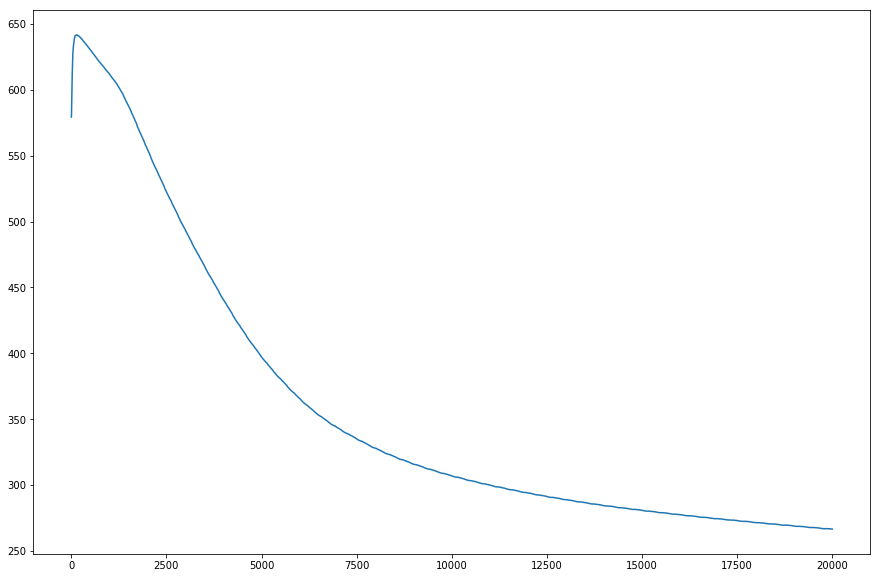

In [17]:
# plt.plot(range(len(r.smooth_loss_list)), r.smooth_loss_list)
# plt.show()
plt.plot(range(len(s.smooth_loss_list)), s.smooth_loss_list)
plt.show()